In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.optimize import minimize
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Cell 2: Load and Explore Data
# Load the Excel file
df = pd.read_excel('FacoDMEK.xlsx', sheet_name='Cleaned Data')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (97, 29)

Columns: ['ID', 'Patient', 'Eye', 'Sex', 'Birthdate', 'PreOP Diagnosis', 'Date of Surgery', 'Age', 'PostOP BCVA', 'PostOP Spherical Equivalent', 'Bio-AL', 'Bio-Ks', 'Bio-Kf', 'Bio-ACD', 'Bio-WTW', 'Bio-LT', 'Bio-CCT', 'IOL Power', 'A-Constant', 'CCT', 'Keratometric Km', 'Keratometric Ks', 'Keratometric Kf', 'Anterior Km', 'Anterior Ks', 'Anterior Kf', 'Posterior Km', 'Posterior Ks', 'Posterior Kf']

First few rows:


,ID,Patient,Eye,Sex,Birthdate,PreOP Diagnosis,Date of Surgery,Age,PostOP BCVA,PostOP Spherical Equivalent,...,CCT,Keratometric Km,Keratometric Ks,Keratometric Kf,Anterior Km,Anterior Ks,Anterior Kf,Posterior Km,Posterior Ks,Posterior Kf
0,1,facchin stefano,OS,M,1954-06-01,Fuchs,2021-12-01,67,1,-1.250,...,594,45.70,46.5,44.9,50.9,51.8,50.0,-6.45,-6.7,-6.2
1,2,alberghina andrea,OD,M,1967-06-01,Fuchs,2021-02-03,53,0.6,-3.125,...,699,47.20,48.0,46.4,52.6,53.5,51.7,-6.60,-6.8,-6.4
2,3,ardini adriana,OS,F,1951-06-01,Fuchs,2020-06-24,69,0.9,0.500,...,663,40.70,40.9,40.5,45.3,45.5,45.1,-6.60,-6.9,-6.3
3,4,Attaccalite vincenzo,OS,M,1947-06-01,Fuchs,2021-09-29,74,0.9,-0.750,...,526,43.25,43.5,43.0,48.2,48.5,47.9,-5.60,-5.7,-5.5
4,5,bisi anna maria,OD,F,1941-06-01,Fuchs,2020-10-28,79,0.8,-0.250,...,603,43.70,44.6,42.8,48.7,49.7,47.7,-5.80,-5.9,-5.7


In [3]:
# Cell 3: Missing Data Analysis and Imputation
# First, calculate basic derived columns that we'll need
print("CALCULATING DERIVED COLUMNS")
print("="*50)

# Calculate average keratometry - BIOMETRY VERSION
df['K_avg_Bio'] = (df['Bio-Ks'] + df['Bio-Kf']) / 2

# Calculate average keratometry - TOPOGRAPHY VERSION
df['K_avg_Topo'] = (df['Keratometric Ks'] + df['Keratometric Kf']) / 2

# Calculate the "true" IOL power that would have achieved emmetropia
df['True_IOL'] = df['IOL Power'] - df['PostOP Spherical Equivalent']

# Feature engineering - only create these if we have the necessary columns
if 'Posterior Km' in df.columns and 'Anterior Km' in df.columns:
    df['Post_Ant_Ratio'] = df['Posterior Km'] / df['Anterior Km']

df['K_Astigmatism_Bio'] = df['Bio-Ks'] - df['Bio-Kf']
df['K_Astigmatism_Topo'] = df['Keratometric Ks'] - df['Keratometric Kf']

if 'CCT' in df.columns:
    df['CCT_Normalized'] = df['CCT'] / 550  # Using OCT CCT only

df['K_Diff_Bio_Topo'] = df['K_avg_Bio'] - df['K_avg_Topo']

# Now analyze missing data patterns
print("\nMISSING DATA ANALYSIS")
print("="*50)

# Define all columns we want to check
all_columns = ['Bio-AL', 'Bio-Ks', 'Bio-Kf', 'K_avg_Bio', 'Posterior Km', 'CCT', 
               'A-Constant', 'Post_Ant_Ratio', 'K_Astigmatism_Bio',
               'Keratometric Ks', 'Keratometric Kf', 'K_avg_Topo',
               'Anterior Km', 'Anterior Ks', 'Anterior Kf']

# Filter to only columns that exist in the dataframe
existing_columns = [col for col in all_columns if col in df.columns]

missing_summary = pd.DataFrame({
    'Column': existing_columns,
    'Missing': [df[col].isna().sum() for col in existing_columns],
    'Percentage': [(df[col].isna().sum()/len(df)*100) for col in existing_columns]
})
missing_summary = missing_summary[missing_summary['Missing'] > 0].sort_values('Missing', ascending=False)
print(missing_summary)

# Create a copy for imputation
df_imputed = df.copy()

# STRATEGY 1: Impute Bio-Ks and Bio-Kf from Keratometric values
print("\nSTRATEGY 1: Imputing Bio-Ks and Bio-Kf from Topography")
# Check if we have topography values when biometry is missing
bio_ks_missing = df_imputed['Bio-Ks'].isna()
bio_kf_missing = df_imputed['Bio-Kf'].isna()
topo_ks_available = df_imputed['Keratometric Ks'].notna()
topo_kf_available = df_imputed['Keratometric Kf'].notna()

# Calculate average differences for cases with both measurements
complete_k_cases = df_imputed[(df_imputed['Bio-Ks'].notna()) & 
                               (df_imputed['Keratometric Ks'].notna())]
if len(complete_k_cases) > 0:
    ks_diff = (complete_k_cases['Bio-Ks'] - complete_k_cases['Keratometric Ks']).mean()
    kf_diff = (complete_k_cases['Bio-Kf'] - complete_k_cases['Keratometric Kf']).mean()
    print(f"Average difference Bio-Ks - Keratometric Ks: {ks_diff:.3f} D")
    print(f"Average difference Bio-Kf - Keratometric Kf: {kf_diff:.3f} D")
    
    # Impute Bio-Ks
    can_impute_ks = bio_ks_missing & topo_ks_available
    if can_impute_ks.sum() > 0:
        df_imputed.loc[can_impute_ks, 'Bio-Ks'] = df_imputed.loc[can_impute_ks, 'Keratometric Ks'] + ks_diff
        print(f"Imputed {can_impute_ks.sum()} Bio-Ks values")
    
    # Impute Bio-Kf
    can_impute_kf = bio_kf_missing & topo_kf_available
    if can_impute_kf.sum() > 0:
        df_imputed.loc[can_impute_kf, 'Bio-Kf'] = df_imputed.loc[can_impute_kf, 'Keratometric Kf'] + kf_diff
        print(f"Imputed {can_impute_kf.sum()} Bio-Kf values")

# Recalculate K_avg_Bio
df_imputed['K_avg_Bio'] = (df_imputed['Bio-Ks'] + df_imputed['Bio-Kf']) / 2

# STRATEGY 2: Impute remaining Bio-K values using anterior corneal power
print("\nSTRATEGY 2: Imputing remaining Bio-K from Anterior Corneal Power")
bio_k_still_missing = df_imputed['K_avg_Bio'].isna()
anterior_available = df_imputed['Anterior Km'].notna()

if bio_k_still_missing.sum() > 0 and (bio_k_still_missing & anterior_available).sum() > 0:
    # Calculate relationship between anterior K and bio K
    complete_anterior = df_imputed[(df_imputed['K_avg_Bio'].notna()) & 
                                   (df_imputed['Anterior Km'].notna())]
    if len(complete_anterior) > 5:
        k_anterior_diff = (complete_anterior['K_avg_Bio'] - complete_anterior['Anterior Km']).mean()
        can_use_anterior = bio_k_still_missing & anterior_available
        df_imputed.loc[can_use_anterior, 'K_avg_Bio'] = df_imputed.loc[can_use_anterior, 'Anterior Km'] + k_anterior_diff
        print(f"Imputed {can_use_anterior.sum()} K_avg_Bio values from Anterior K")

# STRATEGY 3: Regression imputation for Posterior Km
print("\nSTRATEGY 3: Regression for Posterior Corneal Power")
if 'Posterior Km' in df_imputed.columns and 'Anterior Km' in df_imputed.columns and 'CCT' in df_imputed.columns:
    posterior_complete = df_imputed[['Anterior Km', 'CCT', 'Posterior Km']].dropna()
    if len(posterior_complete) > 10 and df_imputed['Posterior Km'].isna().sum() > 0:
        X_post = posterior_complete[['Anterior Km', 'CCT']]
        y_post = posterior_complete['Posterior Km']
        reg_posterior = LinearRegression()
        reg_posterior.fit(X_post, y_post)
        
        posterior_missing = df_imputed['Posterior Km'].isna()
        anterior_cct_available = df_imputed['Anterior Km'].notna() & df_imputed['CCT'].notna()
        can_impute_posterior = posterior_missing & anterior_cct_available
        
        if can_impute_posterior.sum() > 0:
            X_pred = df_imputed.loc[can_impute_posterior, ['Anterior Km', 'CCT']]
            df_imputed.loc[can_impute_posterior, 'Posterior Km'] = reg_posterior.predict(X_pred)
            print(f"Imputed {can_impute_posterior.sum()} Posterior Km values")

# STRATEGY 4: Simple imputation for remaining variables
print("\nSTRATEGY 4: Median/Mode imputation")

# CCT - median
if 'CCT' in df_imputed.columns and df_imputed['CCT'].isna().sum() > 0:
    cct_median = df_imputed['CCT'].median()
    n_cct = df_imputed['CCT'].isna().sum()
    df_imputed['CCT'].fillna(cct_median, inplace=True)
    print(f"Imputed {n_cct} CCT values with median: {cct_median:.0f} μm")

# A-Constant - mode
if df_imputed['A-Constant'].isna().sum() > 0:
    a_constant_mode = df_imputed['A-Constant'].mode()[0]
    n_a = df_imputed['A-Constant'].isna().sum()
    df_imputed['A-Constant'].fillna(a_constant_mode, inplace=True)
    print(f"Imputed {n_a} A-Constant values with mode: {a_constant_mode:.2f}")

# Bio-AL - NO imputation (too critical)
if df_imputed['Bio-AL'].isna().sum() > 0:
    print(f"\nWARNING: {df_imputed['Bio-AL'].isna().sum()} Bio-AL values are missing and will NOT be imputed")

# STRATEGY 5: Recalculate derived variables
print("\nSTRATEGY 5: Recalculating derived variables")

# K_Astigmatism_Bio
df_imputed['K_Astigmatism_Bio'] = df_imputed['Bio-Ks'] - df_imputed['Bio-Kf']

# Post_Ant_Ratio
if 'Posterior Km' in df_imputed.columns and 'Anterior Km' in df_imputed.columns:
    has_both = df_imputed['Posterior Km'].notna() & df_imputed['Anterior Km'].notna()
    df_imputed.loc[has_both, 'Post_Ant_Ratio'] = (
        df_imputed.loc[has_both, 'Posterior Km'] / df_imputed.loc[has_both, 'Anterior Km']
    )

# K_Astigmatism_Topo
df_imputed['K_Astigmatism_Topo'] = df_imputed['Keratometric Ks'] - df_imputed['Keratometric Kf']

# CCT_Normalized
if 'CCT' in df_imputed.columns:
    df_imputed['CCT_Normalized'] = df_imputed['CCT'] / 550

# K_Diff_Bio_Topo
df_imputed['K_Diff_Bio_Topo'] = df_imputed['K_avg_Bio'] - df_imputed['K_avg_Topo']

# Final summary
print("\n" + "="*50)
print("IMPUTATION RESULTS SUMMARY")
print("="*50)

# Count complete cases for key analysis columns
key_columns = ['Bio-AL', 'K_avg_Bio', 'IOL Power', 'PostOP Spherical Equivalent', 'A-Constant']
complete_before = df[key_columns].notna().all(axis=1).sum()
complete_after = df_imputed[key_columns].notna().all(axis=1).sum()

print(f"Complete cases before imputation: {complete_before}")
print(f"Complete cases after imputation: {complete_after}")
print(f"Additional cases gained: {complete_after - complete_before}")

# Check which columns still have missing values for ML features
ml_features = ['Bio-AL', 'K_avg_Bio', 'Posterior Km', 'CCT', 'Post_Ant_Ratio', 'K_Astigmatism_Bio', 'A-Constant']
print("\nRemaining missing values in ML features:")
for feat in ml_features:
    if feat in df_imputed.columns:
        n_missing = df_imputed[feat].isna().sum()
        if n_missing > 0:
            print(f"  - {feat}: still has {n_missing} missing values")

# Use df_imputed for all subsequent analysis
df = df_imputed.copy()
print("\nImputed data is now the working dataset.")

CALCULATING DERIVED COLUMNS

MISSING DATA ANALYSIS
               Column  Missing  Percentage
1              Bio-Ks        1    1.030928
2              Bio-Kf        1    1.030928
3           K_avg_Bio        1    1.030928
7      Post_Ant_Ratio        1    1.030928
8   K_Astigmatism_Bio        1    1.030928
12        Anterior Km        1    1.030928
13        Anterior Ks        1    1.030928
14        Anterior Kf        1    1.030928

STRATEGY 1: Imputing Bio-Ks and Bio-Kf from Topography
Average difference Bio-Ks - Keratometric Ks: -0.093 D
Average difference Bio-Kf - Keratometric Kf: -0.281 D
Imputed 1 Bio-Ks values
Imputed 1 Bio-Kf values

STRATEGY 2: Imputing remaining Bio-K from Anterior Corneal Power

STRATEGY 3: Regression for Posterior Corneal Power

STRATEGY 4: Median/Mode imputation

STRATEGY 5: Recalculating derived variables

IMPUTATION RESULTS SUMMARY
Complete cases before imputation: 96
Complete cases after imputation: 97
Additional cases gained: 1

Remaining missing valu

In [4]:
# Cell 4: Data Summary (using imputed data)
print("Summary of key variables (AFTER IMPUTATION):")
print(df[['Bio-AL', 'K_avg_Bio', 'IOL Power', 'PostOP Spherical Equivalent', 'True_IOL', 'CCT']].describe())

# Check for missing values
print("\nMissing values in key columns:")
missing_counts = df[['Bio-AL', 'K_avg_Bio', 'K_avg_Topo', 'IOL Power', 
                     'PostOP Spherical Equivalent', 'True_IOL', 'CCT', 'A-Constant']].isnull().sum()
print(missing_counts)

# Count how many complete cases we have
complete_cases = df[['Bio-AL', 'K_avg_Bio', 'IOL Power', 'PostOP Spherical Equivalent', 'A-Constant']].notna().all(axis=1).sum()
print(f"\nComplete cases for analysis: {complete_cases} out of {len(df)}")

Summary of key variables (AFTER IMPUTATION):
          Bio-AL  K_avg_Bio  IOL Power  PostOP Spherical Equivalent  \
count  97.000000  97.000000  97.000000                    97.000000   
mean   23.831753  43.410032  21.193227                    -0.159794   
std     1.375736   1.931148   4.586236                     1.347348   
min    21.170000  39.175000   0.743056                    -3.875000   
25%    22.930000  42.375000  18.500000                    -1.000000   
50%    23.640000  43.445000  22.000000                     0.000000   
75%    24.590000  44.545000  24.000000                     0.500000   
max    28.230000  48.045000  30.000000                     5.000000   

        True_IOL         CCT  
count  97.000000   97.000000  
mean   21.353021  620.567010  
std     4.586704   79.396278  
min     0.493056  448.000000  
25%    19.000000  568.000000  
50%    22.125000  606.000000  
75%    24.250000  657.000000  
max    30.000000  880.000000  

Missing values in key columns:
Bio-

In [5]:
# Cell 5: Implement SRK/T Formula with NaN Handling (using imputed data)
def calculate_SRKT(AL, K, A_const, nc=1.333):
    """
    Calculate IOL power using SRK/T formula
    Returns NaN if inputs are invalid
    """
    # Check for valid inputs
    if pd.isna(AL) or pd.isna(K) or pd.isna(A_const) or K <= 0 or AL <= 0:
        return np.nan
    
    try:
        # Constants
        na = 1.336
        V = 12
        
        # Corneal radius
        r = 337.5 / K
        
        # Axial length correction
        if AL <= 24.2:
            LCOR = AL
        else:
            LCOR = 3.446 + 1.716 * AL - 0.0237 * AL**2
        
        # Corneal width
        Cw = -5.41 + 0.58412 * LCOR + 0.098 * K
        
        # Corneal height
        H = r - np.sqrt(r**2 - (Cw**2 / 4))
        
        # ACD constant from A-constant
        ACDconst = 0.62467 * A_const - 68.747
        
        # Offset
        offset = ACDconst - 3.336
        
        # Estimated postoperative ACD
        ACDest = H + offset
        
        # Retinal thickness correction
        RETHICK = 0.65696 - 0.02029 * AL
        LOPT = AL + RETHICK
        
        # Calculate IOL power for emmetropia
        ncm1 = nc - 1
        IOL = (1000 * na * (na * r - ncm1 * LOPT)) / ((LOPT - ACDest) * (na * r - ncm1 * ACDest))
        
        return IOL
    except:
        return np.nan

# First, let's diagnose what's missing for SRK/T calculation
print("DIAGNOSTIC: Missing values for SRK/T calculation")
print("="*50)
srkt_required = ['Bio-AL', 'K_avg_Bio', 'A-Constant']
for col in srkt_required:
    missing = df[col].isna().sum()
    print(f"{col}: {missing} missing values")

# Check cases where we can't calculate SRK/T
cant_calculate = df[srkt_required].isna().any(axis=1)
print(f"\nTotal cases where SRK/T cannot be calculated: {cant_calculate.sum()}")

# Show which combination of missing values prevents calculation
print("\nBreakdown of missing patterns:")
missing_patterns = df[cant_calculate][srkt_required].isna()
print(missing_patterns.value_counts())

# Calculate SRK/T predictions using BIOMETRY K values with imputed data
df['SRKT_Prediction_Bio'] = df.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Bio'], row['A-Constant']), 
    axis=1
)
df['SRKT_Error_Bio'] = df['SRKT_Prediction_Bio'] - df['True_IOL']

# Analysis of results
valid_bio = df['SRKT_Error_Bio'].notna()

print("\nSRK/T FORMULA RESULTS (Using Imputed Biometry Data):")
print("="*50)
print(f"Valid predictions: {valid_bio.sum()} out of {len(df)}")
if valid_bio.sum() > 0:
    print(f"Mean Error: {df.loc[valid_bio, 'SRKT_Error_Bio'].mean():.3f} D")
    print(f"Mean Absolute Error: {df.loc[valid_bio, 'SRKT_Error_Bio'].abs().mean():.3f} D")
    print(f"Standard Deviation: {df.loc[valid_bio, 'SRKT_Error_Bio'].std():.3f} D")
    
    # Calculate percentage within target ranges
    within_025 = (df.loc[valid_bio, 'SRKT_Error_Bio'].abs() <= 0.25).sum() / valid_bio.sum() * 100
    within_050 = (df.loc[valid_bio, 'SRKT_Error_Bio'].abs() <= 0.50).sum() / valid_bio.sum() * 100
    within_100 = (df.loc[valid_bio, 'SRKT_Error_Bio'].abs() <= 1.00).sum() / valid_bio.sum() * 100
    
    print(f"\nPercentage of eyes within target:")
    print(f"±0.25 D: {within_025:.1f}%")
    print(f"±0.50 D: {within_050:.1f}%")
    print(f"±1.00 D: {within_100:.1f}%")

DIAGNOSTIC: Missing values for SRK/T calculation
Bio-AL: 0 missing values
K_avg_Bio: 0 missing values
A-Constant: 0 missing values

Total cases where SRK/T cannot be calculated: 0

Breakdown of missing patterns:
Series([], Name: count, dtype: int64)

SRK/T FORMULA RESULTS (Using Imputed Biometry Data):
Valid predictions: 67 out of 97
Mean Error: -0.455 D
Mean Absolute Error: 1.934 D
Standard Deviation: 2.579 D

Percentage of eyes within target:
±0.25 D: 7.5%
±0.50 D: 17.9%
±1.00 D: 25.4%


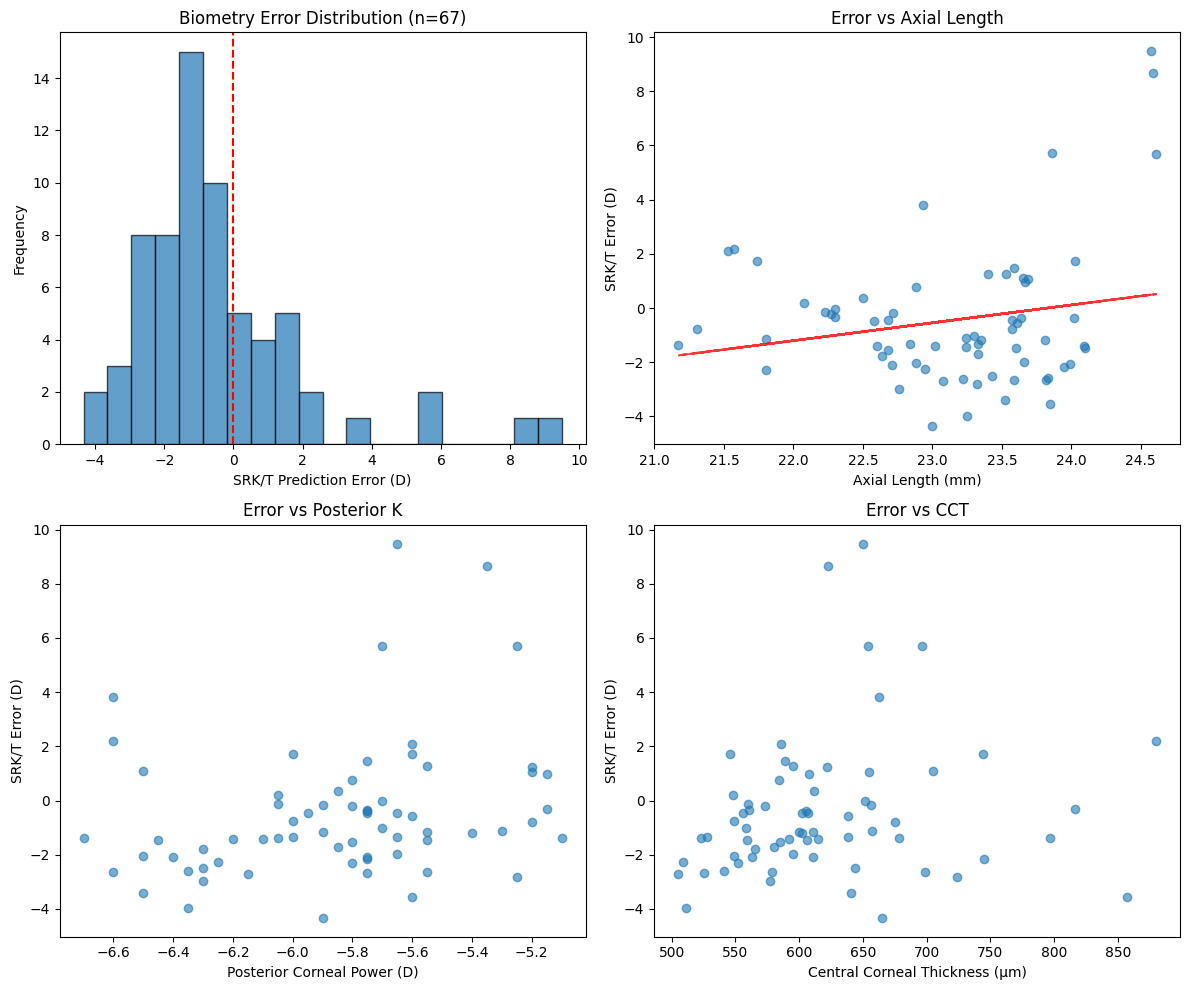


Error Analysis by Axial Length Groups:
                  count      mean       std       MAE
AL_group                                             
Short (<22)           7  0.063585  1.877948  1.654982
Normal (22-24.5)     57 -0.960461  1.800713  1.651643
Long (24.5-26)        3  7.946621  1.990941  7.946621
Very Long (>26)       0       NaN       NaN       NaN


In [6]:
# Cell 6: Visualize SRK/T Performance (with NaN handling)
# Only plot for rows with valid data
df_valid_bio = df[df['SRKT_Error_Bio'].notna()].copy()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Biometry Error Distribution
if len(df_valid_bio) > 0:
    axes[0, 0].hist(df_valid_bio['SRKT_Error_Bio'], bins=20, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(x=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('SRK/T Prediction Error (D)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title(f'Biometry Error Distribution (n={len(df_valid_bio)})')

# Plot 2: Error vs Axial Length
if len(df_valid_bio) > 0:
    axes[0, 1].scatter(df_valid_bio['Bio-AL'], df_valid_bio['SRKT_Error_Bio'], alpha=0.6)
    axes[0, 1].set_xlabel('Axial Length (mm)')
    axes[0, 1].set_ylabel('SRK/T Error (D)')
    axes[0, 1].set_title('Error vs Axial Length')
    # Add trend line
    z = np.polyfit(df_valid_bio['Bio-AL'], df_valid_bio['SRKT_Error_Bio'], 1)
    p = np.poly1d(z)
    axes[0, 1].plot(df_valid_bio['Bio-AL'], p(df_valid_bio['Bio-AL']), "r--", alpha=0.8)

# Plot 3: Error vs Posterior Corneal Power
if len(df_valid_bio) > 0 and 'Posterior Km' in df_valid_bio.columns:
    valid_posterior = df_valid_bio[df_valid_bio['Posterior Km'].notna()]
    if len(valid_posterior) > 0:
        axes[1, 0].scatter(valid_posterior['Posterior Km'], valid_posterior['SRKT_Error_Bio'], alpha=0.6)
        axes[1, 0].set_xlabel('Posterior Corneal Power (D)')
        axes[1, 0].set_ylabel('SRK/T Error (D)')
        axes[1, 0].set_title('Error vs Posterior K')

# Plot 4: Error vs CCT
if len(df_valid_bio) > 0 and 'CCT' in df_valid_bio.columns:
    valid_cct = df_valid_bio[df_valid_bio['CCT'].notna()]
    if len(valid_cct) > 0:
        axes[1, 1].scatter(valid_cct['CCT'], valid_cct['SRKT_Error_Bio'], alpha=0.6)
        axes[1, 1].set_xlabel('Central Corneal Thickness (μm)')
        axes[1, 1].set_ylabel('SRK/T Error (D)')
        axes[1, 1].set_title('Error vs CCT')

plt.tight_layout()
plt.show()

# Additional analysis: Check for systematic bias by AL groups
print("\nError Analysis by Axial Length Groups:")
print("="*50)
if len(df_valid_bio) > 0:
    # Define AL groups
    df_valid_bio['AL_group'] = pd.cut(df_valid_bio['Bio-AL'], 
                                       bins=[0, 22, 24.5, 26, 100], 
                                       labels=['Short (<22)', 'Normal (22-24.5)', 'Long (24.5-26)', 'Very Long (>26)'])
    
    # Calculate stats by group
    grouped_stats = df_valid_bio.groupby('AL_group')['SRKT_Error_Bio'].agg(['count', 'mean', 'std'])
    grouped_stats['MAE'] = df_valid_bio.groupby('AL_group')['SRKT_Error_Bio'].apply(lambda x: x.abs().mean())
    
    print(grouped_stats)

In [7]:
# Cell 7: Optimization Approach 1 - Optimize Corneal Refractive Index
# Only use complete cases
df_complete = df[df['SRKT_Error_Bio'].notna()].copy()

def objective_nc(nc_value):
    """Objective function to minimize MAE by optimizing nc"""
    predictions = df_complete.apply(
        lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Bio'], row['A-Constant'], nc=nc_value[0]), 
        axis=1
    )
    errors = predictions - df_complete['True_IOL']
    # Remove any NaN values that might occur
    valid_errors = errors[errors.notna()]
    if len(valid_errors) == 0:
        return 999  # Return large value if no valid predictions
    return np.mean(np.abs(valid_errors))

# Optimize nc
if len(df_complete) > 0:
    result_nc = minimize(objective_nc, x0=[1.333], bounds=[(1.330, 1.340)], method='L-BFGS-B')
    optimal_nc = result_nc.x[0]
    
    # Recalculate with optimal nc
    df_complete['SRKT_Optimized_nc'] = df_complete.apply(
        lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Bio'], row['A-Constant'], nc=optimal_nc), 
        axis=1
    )
    df_complete['SRKT_Error_Optimized_nc'] = df_complete['SRKT_Optimized_nc'] - df_complete['True_IOL']
    
    print(f"Optimal corneal refractive index: {optimal_nc:.4f}")
    print(f"Original MAE: {df_complete['SRKT_Error_Bio'].abs().mean():.3f} D")
    print(f"Optimized MAE: {df_complete['SRKT_Error_Optimized_nc'].abs().mean():.3f} D")
else:
    print("Not enough complete cases for optimization")

Optimal corneal refractive index: 1.3300
Original MAE: 1.934 D
Optimized MAE: 1.734 D


In [8]:
# Cell 8: Optimization Approach 2 - Linear Correction Model
# Prepare features for correction model
feature_cols = ['Posterior Km', 'CCT', 'Post_Ant_Ratio', 'K_Astigmatism_Bio']

# Ensure we have all necessary columns
required_cols = feature_cols + ['SRKT_Error_Bio']
df_ml = df[df[required_cols].notna().all(axis=1)].copy()

print(f"Complete cases for ML: {len(df_ml)} out of {len(df)}")

if len(df_ml) > 10:  # Need at least 10 cases for meaningful analysis
    X = df_ml[feature_cols]
    y = df_ml['SRKT_Error_Bio']
    
    # Split data for cross-validation
    loo = LeaveOneOut()
    predictions_linear = []
    true_values = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train linear model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predict correction
        correction = model.predict(X_test)[0]
        
        # Apply correction to SRK/T prediction
        srkt_pred = df_ml.iloc[test_index]['SRKT_Prediction_Bio'].values[0]
        corrected_pred = srkt_pred - correction
        
        predictions_linear.append(corrected_pred)
        true_values.append(df_ml.iloc[test_index]['True_IOL'].values[0])
    
    # Calculate performance
    mae_original = df_ml['SRKT_Error_Bio'].abs().mean()
    mae_linear = mean_absolute_error(true_values, predictions_linear)
    
    print(f"Original SRK/T MAE: {mae_original:.3f} D")
    print(f"Linear Correction Model MAE: {mae_linear:.3f} D")
    print(f"Improvement: {mae_original - mae_linear:.3f} D")
    
    # Show feature importance
    model_full = LinearRegression()
    model_full.fit(X, y)
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': model_full.coef_,
        'Abs_Coefficient': np.abs(model_full.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\nFeature Importance (Linear Model):")
    print(feature_importance)
else:
    print("Not enough complete cases for machine learning analysis")

Complete cases for ML: 66 out of 97
Original SRK/T MAE: 1.943 D
Linear Correction Model MAE: 1.713 D
Improvement: 0.230 D

Feature Importance (Linear Model):
             Feature  Coefficient  Abs_Coefficient
2     Post_Ant_Ratio  -300.942300       300.942300
0       Posterior Km     5.868666         5.868666
3  K_Astigmatism_Bio    -0.126271         0.126271
1                CCT     0.005997         0.005997


In [9]:
# Cell 9: Machine Learning Models Comparison
if len(df_ml) > 10:
    # Prepare features
    features_ml = ['Bio-AL', 'K_avg_Bio', 'Posterior Km', 'CCT', 'Post_Ant_Ratio', 
                   'K_Astigmatism_Bio', 'A-Constant']
    
    # Ensure complete cases
    df_ml_full = df[features_ml + ['True_IOL']].dropna()
    X_ml = df_ml_full[features_ml]
    y_ml = df_ml_full['True_IOL']
    
    print(f"Cases for ML comparison: {len(X_ml)}")
    
    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
    }
    
    # Cross-validation results
    results = {}
    
    for name, model in models.items():
        predictions = []
        actuals = []
        
        for train_idx, test_idx in loo.split(X_ml):
            X_train, X_test = X_ml.iloc[train_idx], X_ml.iloc[test_idx]
            y_train, y_test = y_ml.iloc[train_idx], y_ml.iloc[test_idx]
            
            model.fit(X_train, y_train)
            pred = model.predict(X_test)[0]
            
            predictions.append(pred)
            actuals.append(y_test.values[0])
        
        mae = mean_absolute_error(actuals, predictions)
        results[name] = mae
        print(f"{name} MAE: {mae:.3f} D")
    
    # Compare with original SRK/T
    original_mae = df_ml_full.merge(df[['SRKT_Error_Bio']], left_index=True, right_index=True)['SRKT_Error_Bio'].abs().mean()
    print(f"\nOriginal SRK/T MAE: {original_mae:.3f} D")
    print(f"Best ML Model: {min(results, key=results.get)} with MAE: {min(results.values()):.3f} D")

Cases for ML comparison: 96
Linear Regression MAE: 1.656 D
Ridge Regression MAE: 1.593 D
Random Forest MAE: 2.091 D
Gradient Boosting MAE: 2.083 D

Original SRK/T MAE: 1.943 D
Best ML Model: Ridge Regression with MAE: 1.593 D


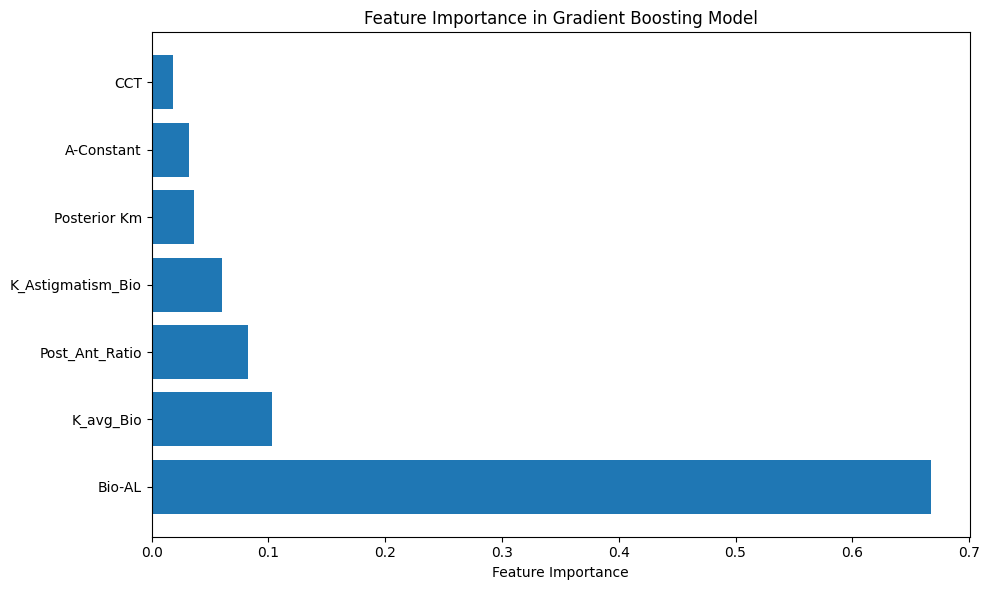

Feature Importance:
             Feature  Importance
0             Bio-AL    0.667102
1          K_avg_Bio    0.102997
4     Post_Ant_Ratio    0.082862
5  K_Astigmatism_Bio    0.060223
2       Posterior Km    0.036081
6         A-Constant    0.032285
3                CCT    0.018449

Simplified Correction Formula:
Correction = 5.598
           + -1.2411 × Posterior Km
           + -0.0045 × CCT
           + -0.4154 × Bio-AL

Final simplified formula MAE: 1.705 D


In [10]:
# Cell 10: Create Final Optimized Formula
if len(df_ml) > 10:
    # Train final model on all data
    best_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
    best_model.fit(X_ml, y_ml)
    
    # Feature importance
    feature_importance_gb = pd.DataFrame({
        'Feature': features_ml,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_gb['Feature'], feature_importance_gb['Importance'])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance in Gradient Boosting Model')
    plt.tight_layout()
    plt.show()
    
    print("Feature Importance:")
    print(feature_importance_gb)
    
    # Create simplified correction formula based on top 3 features
    top_features = ['Posterior Km', 'CCT', 'Bio-AL']
    
    # Ensure we have complete data for these features
    df_simple = df[top_features + ['True_IOL', 'SRKT_Prediction_Bio']].dropna()
    X_simple = df_simple[top_features]
    y_correction = df_simple['True_IOL'] - df_simple['SRKT_Prediction_Bio']
    
    model_simple = LinearRegression()
    model_simple.fit(X_simple, y_correction)
    
    print(f"\nSimplified Correction Formula:")
    print(f"Correction = {model_simple.intercept_:.3f}")
    for feat, coef in zip(top_features, model_simple.coef_):
        print(f"           + {coef:.4f} × {feat}")
    
    # Calculate final performance
    df_simple['Predicted_Correction'] = model_simple.predict(X_simple)
    df_simple['Final_Prediction'] = df_simple['SRKT_Prediction_Bio'] + df_simple['Predicted_Correction']
    final_mae = mean_absolute_error(df_simple['True_IOL'], df_simple['Final_Prediction'])
    
    print(f"\nFinal simplified formula MAE: {final_mae:.3f} D")

In [11]:
# Cell 11: Final Validation and Results Summary
if len(df_ml) > 10:
    # Summary statistics
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    print(f"Original data points: {len(df)}")
    print(f"Complete cases for analysis: {len(df_ml)}")
    print(f"\nOriginal SRK/T Performance:")
    print(f"  MAE: {df_ml['SRKT_Error_Bio'].abs().mean():.3f} D")
    print(f"  Mean Error: {df_ml['SRKT_Error_Bio'].mean():.3f} D")
    print(f"  STD: {df_ml['SRKT_Error_Bio'].std():.3f} D")
    
    if 'optimal_nc' in locals():
        print(f"\nOptimized nc: {optimal_nc:.4f}")
    
    print("\n" + "="*50)
    print("RECOMMENDED FORMULA FOR FACODMEK:")
    print("="*50)
    print("Modified_IOL = Standard_SRK/T + Correction")
    print(f"\nWhere Correction = {model_simple.intercept_:.3f} + "
          f"{model_simple.coef_[0]:.4f}×Posterior_Km + "
          f"{model_simple.coef_[1]:.4f}×CCT + "
          f"{model_simple.coef_[2]:.4f}×AL")
    
    # Save results
    results_df = df_ml[['ID', 'Patient', 'Eye', 'Bio-AL', 'K_avg_Bio', 'IOL Power', 
                        'PostOP Spherical Equivalent', 'True_IOL', 'SRKT_Prediction_Bio', 
                        'SRKT_Error_Bio']].copy()
    
    results_df.to_excel('FacoDMEK_Optimization_Results.xlsx', index=False)
    print("\nResults saved to 'FacoDMEK_Optimization_Results.xlsx'")
else:
    print("Insufficient data for complete analysis")

FINAL RESULTS SUMMARY
Original data points: 97
Complete cases for analysis: 66

Original SRK/T Performance:
  MAE: 1.943 D
  Mean Error: -0.441 D
  STD: 2.596 D

Optimized nc: 1.3300

RECOMMENDED FORMULA FOR FACODMEK:
Modified_IOL = Standard_SRK/T + Correction

Where Correction = 5.598 + -1.2411×Posterior_Km + -0.0045×CCT + -0.4154×AL

Results saved to 'FacoDMEK_Optimization_Results.xlsx'
